# Boston Housing Predict

For this notebook, I am going to build and test data from the Boston Housing dataset on Kaggle.

* https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset

The purpose of the Boston Housing dataset is to utilize a regression model to predict the median value for houses in Boston.

## Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [1]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [2]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

## Imports

In [3]:
import datetime
import logging
import random
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import ml_toolbox
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [4]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-06 18:54:58.800807


In [5]:
tf.__version__

'2.13.0'

In [6]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [7]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [8]:
RANDOM_SEED = 27

## Helpers 
Defining helper functions to split certain functionality out of tasks.

In [54]:
ActivationType = typing.Union[str, typing.Callable[[tf.Tensor], tf.Tensor]]

class SkipConnectionDenseLayer(tf.keras.layers.Layer):

    def __init__(self,
                 units: int = 32,
                 hidden_layers: int = 1,
                 activation: typing.Optional[ActivationType] = None,
                 *args,
                 **kwargs):
        """ Skip connection dense layer.

            Args:
                units (int): the number of units in the layer.
                hidden_layers (int): the number of hidden layers in the layer.
                activation (Optional[ActivationType]): the activation function to use.
        """
        super().__init__(*args, **kwargs)
        activation = activation or 'relu'
        self.hidden_layers = [tf.keras.layers.Dense(units, activation=activation) for _ in range(hidden_layers)]
        self.sum_layer = tf.keras.layers.Add()

    def call(self, inputs: tf.Tensor, *args, **kwargs) -> tf.Tensor:
        """ Forward pass of the layer.

            Args:
                inputs (tf.Tensor): the input tensor to the layer.

            Returns:
                (tf.Tensor) the output of the layer.
        """
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.sum_layer([inputs, x])
        return x


## Downloading, Analyzing, & Creating Datasets

The data used in the paper is publicly available through the TensorFlow API directly.

* https://www.tensorflow.org/api_docs/python/tf/keras/datasets/boston_housing
* http://lib.stat.cmu.edu/datasets/boston

Features:
* CRIM     per capita crime rate by town
* ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS    proportion of non-retail business acres per town
* CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
* NOX      nitric oxides concentration (parts per 10 million)
* RM       average number of rooms per dwelling
* AGE      proportion of owner-occupied units built prior to 1940
* DIS      weighted distances to five Boston employment centres
* RAD      index of accessibility to radial highways
* TAX      full-value property-tax rate per \$10,000
* PTRATIO  pupil-teacher ratio by town
* B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
* LSTAT    % lower status of the population
* MEDV     Median value of owner-occupied homes in \$1000's

### Data Constants

In [11]:
# Constants
TEST_SPLIT = 0.2

VARIABLE_NAMES = [
    'CRIM',
    'ZN',
    'INDUS',
    'CHAS',
    'NOX',
    'RM',
    'AGE',
    'DIS',
    'RAD',
    'TAX',
    'PTRATIO',
    'B',
    'LSTAT',
    'MEDV',
]

### Download & Split Data

In [12]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=TEST_SPLIT, seed=RANDOM_SEED)

len(X_train), len(y_train), len(X_test), len(y_test)

(404, 404, 102, 102)

### Analyze Data

In [13]:
train_df = pd.DataFrame(tf.concat([X_train, y_train.reshape((-1,1))], axis=1), columns=VARIABLE_NAMES)
test_df = pd.DataFrame(tf.concat([X_test, y_test.reshape((-1,1))], axis=1), columns=VARIABLE_NAMES)
train_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,37.66190,0.0,18.10,0.0,0.679,6.202,78.7,1.8629,24.0,666.0,20.2,18.82,14.52,10.9
1,0.54011,20.0,3.97,0.0,0.647,7.203,81.8,2.1121,5.0,264.0,13.0,392.80,9.59,33.8
2,0.17134,0.0,10.01,0.0,0.547,5.928,88.2,2.4631,6.0,432.0,17.8,344.91,15.76,18.3
3,38.35180,0.0,18.10,0.0,0.693,5.453,100.0,1.4896,24.0,666.0,20.2,396.90,30.59,5.0
4,1.19294,0.0,21.89,0.0,0.624,6.326,97.7,2.2710,4.0,437.0,21.2,396.90,12.26,19.6


In [14]:
X_train.shape, y_train.shape

((404, 13), (404,))

In [15]:
X_train[0], y_train[0]

(array([ 37.6619,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.202 ,
         78.7   ,   1.8629,  24.    , 666.    ,  20.2   ,  18.82  ,
         14.52  ]),
 10.9)

In [16]:
train_df[['ZN', 'CHAS']].value_counts()

ZN     CHAS
0.0    0.0     275
       1.0      25
80.0   0.0      12
20.0   0.0      12
12.5   0.0      10
22.0   0.0       9
25.0   0.0       9
30.0   0.0       4
45.0   0.0       4
40.0   0.0       4
60.0   0.0       3
95.0   0.0       3
90.0   0.0       3
21.0   0.0       3
40.0   1.0       3
75.0   0.0       3
70.0   0.0       2
85.0   0.0       2
82.5   0.0       2
28.0   0.0       2
33.0   0.0       2
55.0   0.0       2
20.0   1.0       2
35.0   0.0       2
34.0   0.0       2
18.0   0.0       1
52.5   0.0       1
90.0   1.0       1
100.0  0.0       1
Name: count, dtype: int64

In [17]:
X_train[0]

array([ 37.6619,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.202 ,
        78.7   ,   1.8629,  24.    , 666.    ,  20.2   ,  18.82  ,
        14.52  ])

### Preprocess Data

After analyzing the data, it is apparent I need to do some scaling on non-categorical data.

In [18]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(train_df[train_df.columns.difference(['CHAS', 'MEDV'])])

train_transformed_less_chas = min_max_scaler.transform(train_df[train_df.columns.difference(['CHAS', 'MEDV'])])
test_transformed_less_chas = min_max_scaler.transform(test_df[test_df.columns.difference(['CHAS', 'MEDV'])])

X_train_scaled = tf.concat([train_transformed_less_chas, X_train[:, 3].reshape((-1, 1))], axis=1)
X_test_scaled = tf.concat([test_transformed_less_chas, X_test[:, 3].reshape((-1, 1))], axis=1)

X_train_scaled[3], X_test_scaled[3]

(<tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([1.        , 1.        , 0.43099395, 0.0327365 , 0.64662757,
        0.8187234 , 0.63374486, 0.80851064, 1.        , 0.36252156,
        0.91412214, 0.        , 0.        ])>,
 <tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([0.15962925, 0.96648848, 0.00097044, 0.39666633, 0.2063783 ,
        0.19687943, 0.09876543, 0.37234043, 0.26086957, 0.56217666,
        0.27099237, 0.34      , 0.        ])>)

### Create Datasets

In [19]:
X_train_scaled[3], y_train[3]

(<tf.Tensor: shape=(13,), dtype=float64, numpy=
 array([1.        , 1.        , 0.43099395, 0.0327365 , 0.64662757,
        0.8187234 , 0.63374486, 0.80851064, 1.        , 0.36252156,
        0.91412214, 0.        , 0.        ])>,
 5.0)

In [20]:
train_dataset = data_toolbox.generate_dataset_from_data([X_train_scaled], y_train)
test_dataset = data_toolbox.generate_dataset_from_data([X_test_scaled], y_test)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float64, name=None),), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 13), dtype=tf.float64, name=None),), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

## Experiments

* Experiment-0: Simple Feed Forward
* Experiment-1: Simple Feed Forward w/ Non-linear Activation
* Experiment-2: Deep NN w/ Non-linear Activation
* Experiment-3: Skip Connection Model w/ Non-linear Acivation

### Constants

In [21]:
INPUT_SIZE = 13
OUTPUT_SIZE = 1

### Experiment-0: Simple Feed Forward

In [22]:
# Constants
model_0_name = 'model_0_simple'

In [23]:
model_0 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Dense(16),
    tf.keras.layers.Dense(OUTPUT_SIZE),
], name=model_0_name)

model_0.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_0_history = model_0.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 6ms/step - loss: 23.1524 - mae: 23.1524 - mse: 620.0460 - val_loss: 23.5373 - val_mae: 23.5373 - val_mse: 627.4219
Epoch 2/100
13/13 [==============================] - 0s 877us/step - loss: 22.7019 - mae: 22.7019 - mse: 600.1445 - val_loss: 23.1042 - val_mae: 23.1042 - val_mse: 607.7313
Epoch 3/100
13/13 [==============================] - 0s 872us/step - loss: 22.2410 - mae: 22.2410 - mse: 580.1848 - val_loss: 22.6559 - val_mae: 22.6559 - val_mse: 587.7332
Epoch 4/100
13/13 [==============================] - 0s 962us/step - loss: 21.7605 - mae: 21.7605 - mse: 559.8320 - val_loss: 22.1852 - val_mae: 22.1852 - val_mse: 567.1727
Epoch 5/100
13/13 [==============================] - 0s 976us/step - loss: 21.2535 - mae: 21.2535 - mse: 538.8712 - val_loss: 21.6859 - val_mae: 21.6859 - val_mse: 545.8571
Epoch 6/100
13/13 [==============================] - 0s 874us/step - loss: 20.7138 - mae: 20.7138 - mse: 517.1364 - val_loss: 21.1522 - v

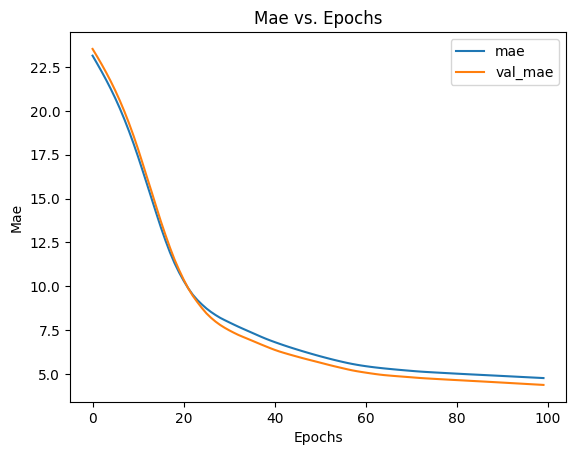

In [24]:
ml_toolbox.analysis.history.plot_history(model_0_history, 'mae')

In [25]:
model_0_preds = model_0.predict(test_dataset)

model_0_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_0_preds), model_0_name)
model_0_results

4/4 [==============================] - 0s 731us/step


RegressionPredictionMetrics(mae=4.3725934, mse=42.69272, rmse=6.5339665, mape=17.737299, mase=0.4561842, huber=3.9098072, name='model_0_simple')

### Experiment-1: Simple Feed Foward w/ Non-Linear Activation

In [26]:
# Constants
model_1_name = 'model_1_single_hidden_relu'

In [27]:
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_SIZE,)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_SIZE),
], name=model_1_name)

model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_1_history = model_1.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 5ms/step - loss: 21.9472 - mae: 21.9472 - mse: 567.6483 - val_loss: 22.4528 - val_mae: 22.4528 - val_mse: 579.6993
Epoch 2/100
13/13 [==============================] - 0s 983us/step - loss: 21.6156 - mae: 21.6156 - mse: 553.8727 - val_loss: 22.1416 - val_mae: 22.1416 - val_mse: 566.3439
Epoch 3/100
13/13 [==============================] - 0s 898us/step - loss: 21.2824 - mae: 21.2824 - mse: 540.3273 - val_loss: 21.8196 - val_mae: 21.8196 - val_mse: 552.7264
Epoch 4/100
13/13 [==============================] - 0s 876us/step - loss: 20.9276 - mae: 20.9276 - mse: 526.1636 - val_loss: 21.4703 - val_mae: 21.4703 - val_mse: 538.2215
Epoch 5/100
13/13 [==============================] - 0s 897us/step - loss: 20.5371 - mae: 20.5371 - mse: 510.9825 - val_loss: 21.0872 - val_mae: 21.0872 - val_mse: 522.6653
Epoch 6/100
13/13 [==============================] - 0s 873us/step - loss: 20.1151 - mae: 20.1151 - mse: 494.9681 - val_loss: 20.6730 - v

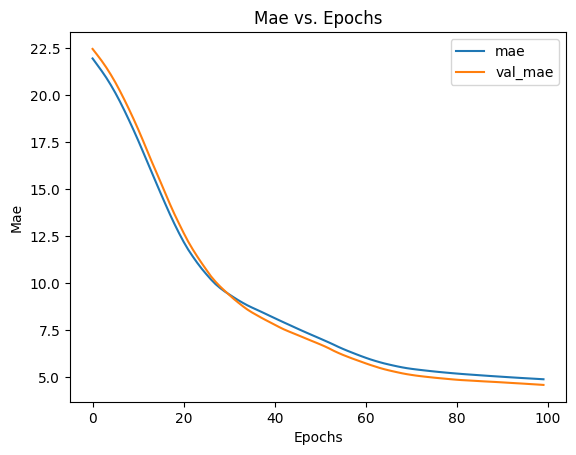

In [28]:
ml_toolbox.analysis.history.plot_history(model_1_history, 'mae')

In [29]:
model_1_preds = model_1.predict(test_dataset)

model_1_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_1_preds), model_1_name)
model_1_results

4/4 [==============================] - 0s 922us/step


RegressionPredictionMetrics(mae=4.5935993, mse=47.73959, rmse=6.9093843, mape=18.382433, mase=0.4792413, huber=4.1252317, name='model_1_single_hidden_relu')

### Experiment-2: Deep Neural Net w/ Non-Linear Activation

In [30]:
# Constants
model_2_name = 'model_2_deep_net'

NUM_HIDDEN_LAYERS_2 = 15
NUM_NEURONS_PER_HIDDEN_2 = 32

In [31]:
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,))

x = inputs
for _ in range(NUM_HIDDEN_LAYERS_2):
    x = tf.keras.layers.Dense(NUM_NEURONS_PER_HIDDEN_2, activation='relu')(x)

outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu')(x)

model_2 = tf.keras.models.Model(inputs, outputs, name=model_2_name)

model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_2_history = model_2.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 1s 8ms/step - loss: 22.3254 - mae: 22.3254 - mse: 584.9449 - val_loss: 22.8299 - val_mae: 22.8299 - val_mse: 597.0425
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 21.4520 - mae: 21.4520 - mse: 548.0400 - val_loss: 20.2010 - val_mae: 20.2010 - val_mse: 488.1632
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 13.6892 - mae: 13.6892 - mse: 279.9916 - val_loss: 10.0030 - val_mae: 10.0030 - val_mse: 168.5764
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 10.0509 - mae: 10.0509 - mse: 166.3198 - val_loss: 9.0786 - val_mae: 9.0786 - val_mse: 138.1998
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 8.0433 - mae: 8.0433 - mse: 112.3521 - val_loss: 6.9522 - val_mae: 6.9522 - val_mse: 91.6582
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 6.6804 - mae: 6.6804 - mse: 85.8724 - val_loss: 5.6859 - val_mae: 5.6859 - val_

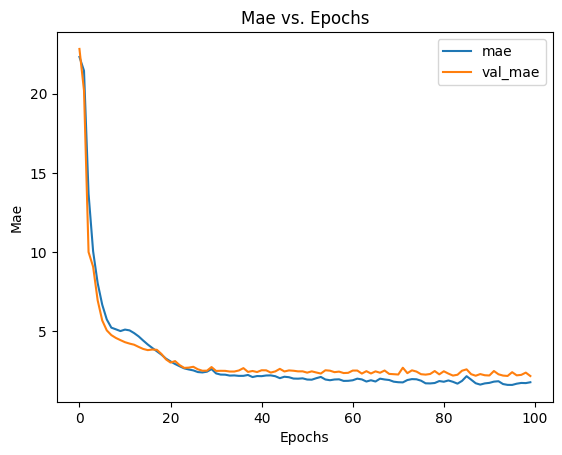

In [32]:
ml_toolbox.analysis.history.plot_history(model_2_history, 'mae')

In [33]:
model_2_preds = model_2.predict(test_dataset)

model_2_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_2_preds), model_2_name)
model_2_results

4/4 [==============================] - 0s 817us/step


RegressionPredictionMetrics(mae=2.1746728, mse=8.669317, rmse=2.9443705, mape=10.246125, mase=0.2268794, huber=1.7424283, name='model_2_deep_net')

### Experiment-3: Skip Neural Network w/ Non-Linear Activation

In [56]:
# Constants
model_3_name = 'model_3_skip_nn'

In [69]:
inputs = tf.keras.layers.Input(shape=(INPUT_SIZE,))
x = tf.keras.layers.Dense(64)(inputs)
x = SkipConnectionDenseLayer(64, hidden_layers=6)(x)
x = tf.keras.layers.Dense(32)(inputs)
x = SkipConnectionDenseLayer(32, hidden_layers=6)(x)
x = tf.keras.layers.Dense(16)(inputs)
x = SkipConnectionDenseLayer(16, hidden_layers=6)(x)
outputs = tf.keras.layers.Dense(OUTPUT_SIZE, activation='relu')(x)

model_3 = tf.keras.models.Model(inputs, outputs, name=model_3_name)

model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['mae', 'mse'])

model_3_history = model_3.fit(train_dataset,
                              validation_data=test_dataset,
                              epochs=100)

Epoch 1/100
13/13 [==============================] - 0s 8ms/step - loss: 22.1538 - mae: 22.1538 - mse: 576.4268 - val_loss: 22.5057 - val_mae: 22.5057 - val_mse: 581.0433
Epoch 2/100
13/13 [==============================] - 0s 1ms/step - loss: 21.4386 - mae: 21.4386 - mse: 544.8375 - val_loss: 21.5385 - val_mae: 21.5385 - val_mse: 539.1540
Epoch 3/100
13/13 [==============================] - 0s 1ms/step - loss: 20.1214 - mae: 20.1214 - mse: 491.2820 - val_loss: 19.6691 - val_mae: 19.6691 - val_mse: 463.8234
Epoch 4/100
13/13 [==============================] - 0s 1ms/step - loss: 17.3497 - mae: 17.3497 - mse: 391.6100 - val_loss: 15.6111 - val_mae: 15.6111 - val_mse: 326.3878
Epoch 5/100
13/13 [==============================] - 0s 1ms/step - loss: 12.0593 - mae: 12.0593 - mse: 231.8883 - val_loss: 9.2125 - val_mae: 9.2125 - val_mse: 145.2497
Epoch 6/100
13/13 [==============================] - 0s 1ms/step - loss: 8.4968 - mae: 8.4968 - mse: 124.1879 - val_loss: 7.4950 - val_mae: 7.4950 

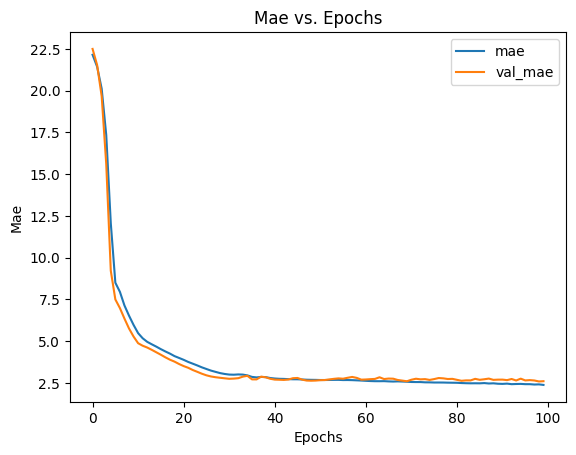

In [70]:
ml_toolbox.analysis.history.plot_history(model_3_history, 'mae')

In [71]:
model_3_preds = model_3.predict(test_dataset)

model_3_results = ml_toolbox.analysis.regression.generate_prediction_metrics(y_test, tf.squeeze(model_3_preds), model_3_name)
model_3_results

4/4 [==============================] - 0s 1ms/step


RegressionPredictionMetrics(mae=2.596233, mse=12.286273, rmse=3.505178, mape=12.119926, mase=0.27085996, huber=2.1472216, name='model_3_skip_nn')